In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings

## Pré-processamento dos dados 

### Carregando e visualizando os dados

In [2]:
df = pd.read_excel('base_temporais.xlsx')

# Limpando a coluna data e tranformando em datetime
df = df[pd.to_datetime(df['data'], errors='coerce').notna()]
df['data'] = pd.to_datetime(df['data'])

# Configurar a coluna 'data' como índice
df.set_index('data', inplace=True)

In [3]:
df.head()

,quantidade_dossies
data,
2021-01-01,7
2021-02-01,5
2021-03-01,1
2021-04-01,5
2021-05-01,6


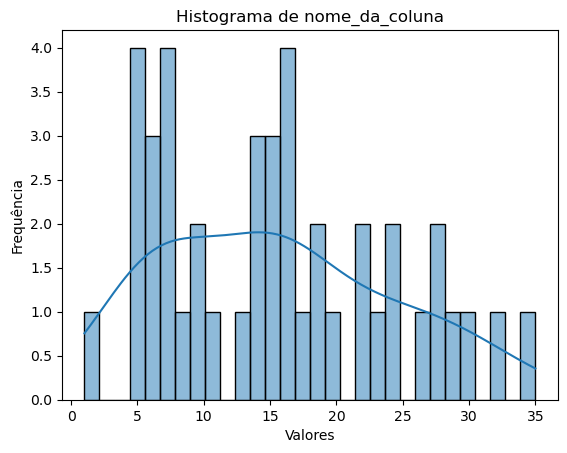

In [4]:
import seaborn as sns
warnings.filterwarnings("ignore")

# Supondo que você tenha um DataFrame chamado df e uma coluna chamada 'nome_da_coluna'
sns.histplot(df['quantidade_dossies'], bins=30, kde=True)

plt.title('Histograma de nome_da_coluna')
plt.xlabel('Valores')
plt.ylabel('Frequência')

plt.show()

### Tratamento para estabilização da série (série estacionária)

Para aplicação do algororítmo de SARIMA precisamos de séries temporais estacionárias, ou seja, suas propriedades estatísticas como média e variância não devem mudar ao longo do tempo!

Aplicando teste de ADF, para veriricar se a série é estacionária ou não.

In [5]:
# Verificando se a série temporal é estacionária para aplicar o algorítmo SARIMA
# Precisamos que a série seja estacionária e os resíduos sejam uma distribuição normal

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Aplicando o teste ADF
result = adfuller(df['quantidade_dossies'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -1.4885383637441412
p-value: 0.5391734352483737
Critical Value 1%: -3.596635636000432
Critical Value 5%: -2.933297331821618
Critical Value 10%: -2.6049909750566895


Precisamos verificar se o p-valor é menor que 0.05 e se o valor do teste ADF é menos que os valores críticos também calculados. Ao fazer essa análise concluímos que nossa série não é estacionária, teremos que aplicar algumas transformações no dados.

Aplicar Diferenciação: Subtrair o valor anterior da série corrente. Isso remove tendências e ajuda a estabilizar a média.

In [6]:
df['imoveis_retornados_diff'] = df['quantidade_dossies'].diff().dropna()

# Reaplicando o teste ADF na série diferenciada
result_diff = adfuller(df['imoveis_retornados_diff'].dropna())
print(f'ADF Statistic (Diferenciada): {result_diff[0]}')
print(f'p-value (Diferenciada): {result_diff[1]}')
for key, value in result_diff[4].items():
    print(f'Critical Value {key} (Diferenciada): {value}')

ADF Statistic (Diferenciada): -6.170685484110343
p-value (Diferenciada): 6.817121526186637e-08
Critical Value 1% (Diferenciada): -3.6055648906249997
Critical Value 5% (Diferenciada): -2.937069375
Critical Value 10% (Diferenciada): -2.606985625


Vamos aplicar transformação logarítmica para estabilizar a variância (para série com variância crescente)

In [7]:
import numpy as np

df['log_imoveis_retornados'] = np.log(df['quantidade_dossies'])

# Reaplicando o teste ADF na série logarítmica
result_log = adfuller(df['log_imoveis_retornados'].dropna())
print(f'ADF Statistic (Logarítmica): {result_log[0]}')
print(f'p-value (Logarítmica): {result_log[1]}')
for key, value in result_log[4].items():
    print(f'Critical Value {key} (Logarítmica): {value}')

ADF Statistic (Logarítmica): -3.0457317865482723
p-value (Logarítmica): 0.03083875859966264
Critical Value 1% (Logarítmica): -3.6055648906249997
Critical Value 5% (Logarítmica): -2.937069375
Critical Value 10% (Logarítmica): -2.606985625


## Treinando o modelo

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=111.479, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=115.389, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=115.388, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=136.925, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=113.389, Time=0.12 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=113.389, Time=0.10 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=115.389, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=113.478, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=113.475, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.691 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   31

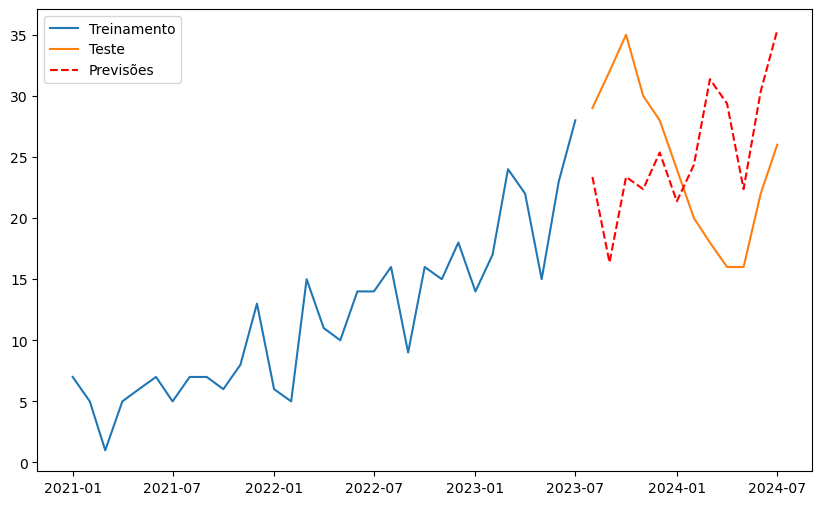

In [8]:
# Dividindo os dados em treinamento e teste (últimos 12 meses para teste)
train = df.iloc[:-12]
test = df.iloc[-12:]

# Encontrando os melhores parâmetros com auto_arima
smodel = auto_arima(train['quantidade_dossies'], 
                    start_p=1, start_q=1, 
                    test='adf',       # para verificar estacionaridade
                    max_p=3, max_q=3, # limites para p e q
                    m=12,             # periodicidade da sazonalidade
                    start_P=0, 
                    seasonal=True, 
                    d=None, D=1, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

print(smodel.summary())

# Fazendo previsões
predictions = smodel.predict(n_periods=12)
predictions = pd.DataFrame(predictions, 
                           index=test.index, 
                           columns=['Previsões'])

# Visualizando os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['quantidade_dossies'], label='Treinamento')
plt.plot(test['quantidade_dossies'], label='Teste')
plt.plot(predictions, label='Previsões', color='red', linestyle='--')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['quantidade_dossies'], predictions)
print(f'MAE: {mae}')


MAE: 8.41666666666667


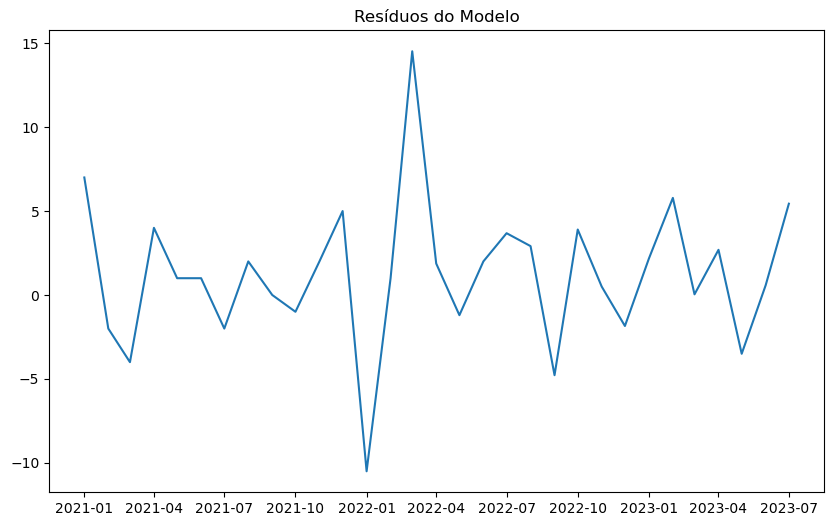

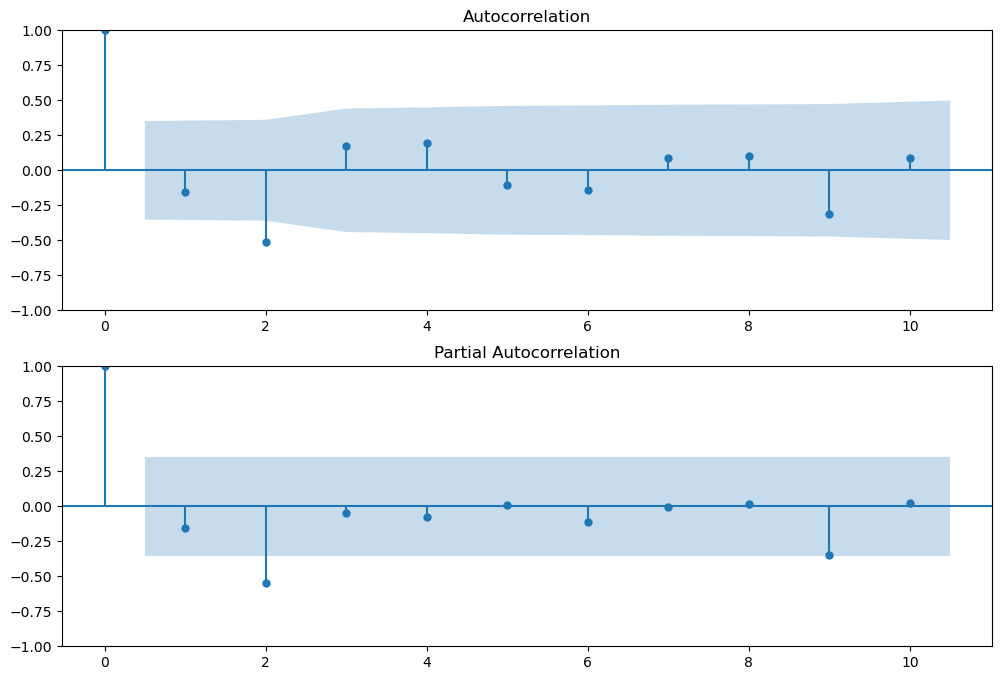

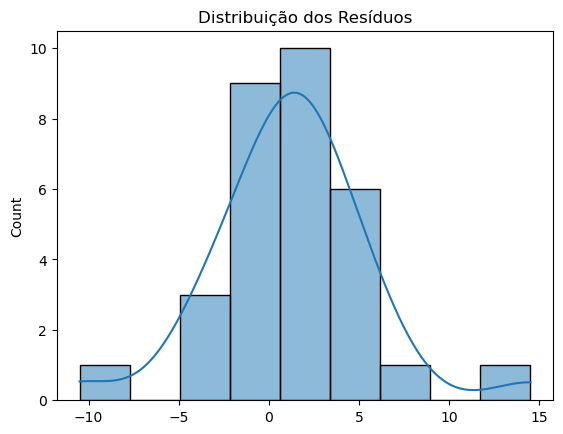

      lb_stat  lb_pvalue
10  19.550481   0.033803


In [10]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


# Ajustando o modelo SARIMA
model = SARIMAX(train['quantidade_dossies'],
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False)

# Fazendo previsões para os próximos 12 meses
predictions = model_fit.get_forecast(steps=12)
predictions_mean = predictions.predicted_mean

# Avaliando os resíduos
residuals = model_fit.resid

# Plotando os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Resíduos do Modelo')
plt.show()

# Análise de Autocorrelação dos Resíduos
lags = min(10, len(residuals) // 2 - 1)  # Definindo o número de lags para ser menor que 50% do tamanho dos resíduos

fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(residuals, ax=ax[0], lags=lags)
plot_pacf(residuals, ax=ax[1], lags=lags)
plt.show()

# Plotando a distribuição dos resíduos
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()

# Teste de hipótese para verificar se os resíduos são ruído branco
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_test = acorr_ljungbox(residuals, lags=[lags], return_df=True)
print(ljung_box_test)

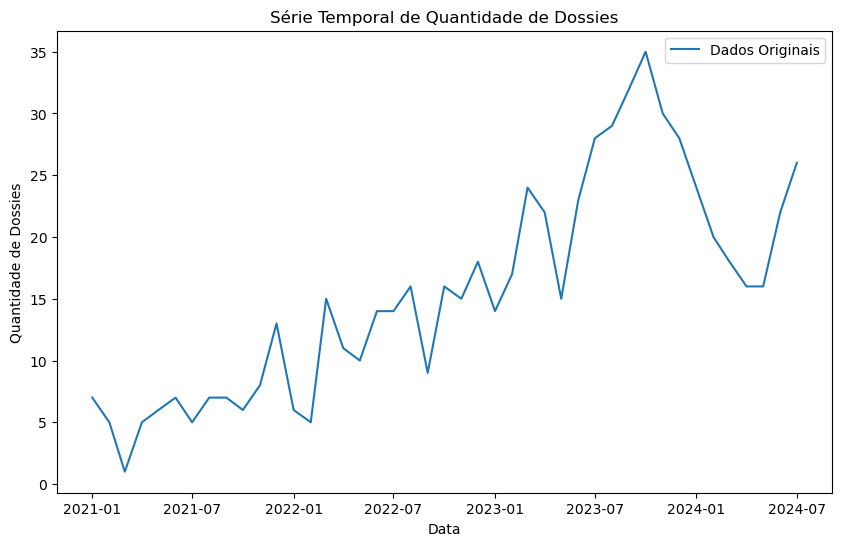

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=111.479, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=115.389, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=115.388, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=136.925, Time=0.00 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=113.389, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=113.389, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=115.389, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=113.478, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=113.475, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.817 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   31

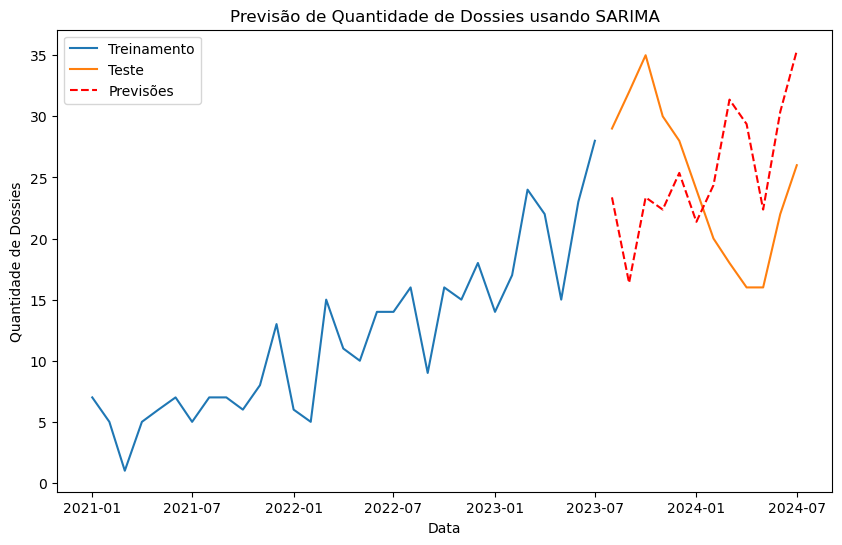

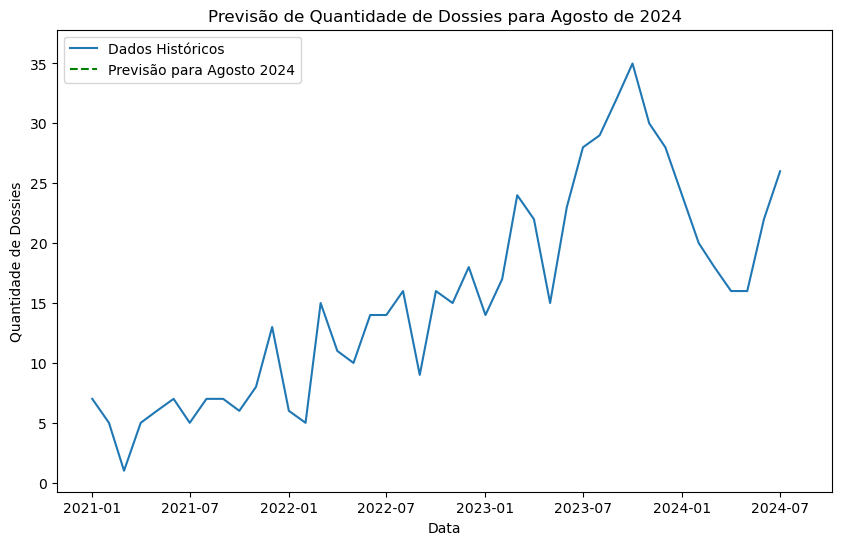

Previsão para Agosto de 2024: 36.064516129032256


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualizando os dados
plt.figure(figsize=(10, 6))
plt.plot(df['quantidade_dossies'], label='Dados Originais')
plt.xlabel('Data')
plt.ylabel('Quantidade de Dossies')
plt.title('Série Temporal de Quantidade de Dossies')
plt.legend()
plt.show()

# Dividindo os dados em treinamento e teste (últimos 12 meses para teste)
train = df.iloc[:-12]
test = df.iloc[-12:]

# Encontrando os melhores parâmetros com auto_arima
smodel = auto_arima(train['quantidade_dossies'], 
                    start_p=1, start_q=1, 
                    test='adf',       # para verificar estacionaridade
                    max_p=3, max_q=3, # limites para p e q
                    m=12,             # periodicidade da sazonalidade
                    start_P=0, 
                    seasonal=True, 
                    d=None, D=1, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

print(smodel.summary())

# Fazendo previsões para o conjunto de teste
predictions = smodel.predict(n_periods=12)
predictions = pd.DataFrame(predictions, 
                           index=test.index, 
                           columns=['Previsões'])

# Avaliando o modelo
mae = mean_absolute_error(test['quantidade_dossies'], predictions['Previsões'])
mse = mean_squared_error(test['quantidade_dossies'], predictions['Previsões'])
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Visualizando os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['quantidade_dossies'], label='Treinamento')
plt.plot(test['quantidade_dossies'], label='Teste')
plt.plot(predictions, label='Previsões', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Quantidade de Dossies')
plt.title('Previsão de Quantidade de Dossies usando SARIMA')
plt.legend()
plt.show()

# Ajustando o modelo aos dados completos e fazendo previsão para o próximo mês
smodel.fit(df['quantidade_dossies'])
next_month_prediction = smodel.predict(n_periods=1)
next_month_date = df.index[-1] + pd.DateOffset(months=1)
next_month_prediction = pd.DataFrame(next_month_prediction, 
                                     index=[next_month_date], 
                                     columns=['Previsão para Agosto 2024'])

# Visualizando a previsão para o próximo mês
plt.figure(figsize=(10, 6))
plt.plot(df['quantidade_dossies'], label='Dados Históricos')
plt.plot(next_month_prediction, label='Previsão para Agosto 2024', color='green', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Quantidade de Dossies')
plt.title('Previsão de Quantidade de Dossies para Agosto de 2024')
plt.legend()
plt.show()

print(f'Previsão para Agosto de 2024: {next_month_prediction.iloc[0, 0]}')
